In [2]:
import numpy as np

mtot = 0.943
m_motor = .052
m_prop = .01
mr = m_motor + m_prop
md = mtot - 4*(m_motor + m_prop)
L = .225
I_single = (m_motor + m_prop) * L**2
h1 = 1
g = 9.81
rho = 1.225
k_drag = 1e-6

Ixx = 2 * I_single
Iyy = 2 * I_single
Izz = 4 * I_single

omega_hover = 400
k_thrust = mtot * g / (4 * omega_hover**2)

# --- Rotor / disk assumptions (tunable) ---
R_rotor = 0.10                         # rotor radius [m] (e.g. ~8 inch prop)
A_disk = np.pi * R_rotor**2           # rotor disk area

# Ideal induced power coefficient from momentum theory:
# T = k_thrust * omega^2
# Ideal hover power P = T^(3/2) / sqrt(2 rho A)
# => P = cP * omega^3, with:
cP_rotor = (k_thrust**1.5) / np.sqrt(2 * rho * A_disk)

# --- Battery assumptions (tunable to match COTS pack) ---
battery_voltage = 11.1        # [V], e.g. 3S LiPo
battery_capacity_Ah = 1.5     # [Ah], e.g. 1500 mAh
battery_energy_J = battery_voltage * battery_capacity_Ah * 3600.0

params = {
    "mtot": mtot, "md": md, "mr": mr, "I": I_single,
    "h1": h1, "g": g, "rho": rho, "L": L,
    "omega_hover": omega_hover, "k_thrust": k_thrust,
    "k_drag": k_drag, "Ixx": Ixx, "Iyy": Iyy, "Izz": Izz, 
    "R_rotor": R_rotor, "A_disk": A_disk, "cP_rotor": cP_rotor, 
    "battery_voltage": battery_voltage, "battery_capacity_Ah": battery_capacity_Ah, 
    "battery_energy_J": battery_energy_J,
}


In [3]:
def rotation(phi, theta, psi):
    cphi, sphi = np.cos(phi), np.sin(phi)
    cth,  sth  = np.cos(theta), np.sin(theta)
    cpsi, spsi = np.cos(psi), np.sin(psi)

    return np.array([
        [cth*cpsi,  cth*spsi, -sth],
        [sphi*sth*cpsi - cphi*spsi, sphi*sth*spsi + cphi*cpsi, sphi*cth],
        [cphi*sth*cpsi + sphi*spsi, cphi*sth*spsi - sphi*cpsi, cphi*cth]
    ])


In [4]:
def euler_rates(phi, theta, psi, p, q, r):
    phi_dot   = p + q*np.sin(phi)*np.tan(theta) + r*np.cos(phi)*np.tan(theta)
    theta_dot =     q*np.cos(phi)               - r*np.sin(phi)
    psi_dot   =     q*np.sin(phi)/np.cos(theta) + r*np.cos(phi)/np.cos(theta)
    return np.array([phi_dot, theta_dot, psi_dot])


In [5]:
def thrust_body(omegas):
    kT = params["k_thrust"]
    return np.array([0, 0, kT * np.sum(omegas**2)])

def torque_body(omegas):
    L = params["L"]
    kT = params["k_thrust"]
    b = params["k_drag"]

    w1, w2, w3, w4 = omegas
    tau_phi   = L * kT * (w1**2 - w3**2)
    tau_theta = L * kT * (w2**2 - w4**2)
    tau_psi   = b * (w1**2 - w2**2 + w3**2 - w4**2)

    return np.array([tau_phi, tau_theta, tau_psi])


In [6]:
def rotor_power(omega, params=params):
    """
    Ideal rotor power (single rotor) using P = cP * omega^3.
    omega: rad/s
    """
    cP = params["cP_rotor"]
    return cP * omega**3

def total_power(omegas, params=params):
    """
    Total electrical power for the quad [W], idealized.
    omegas: array-like [ω1, ω2, ω3, ω4] in rad/s
    """
    return np.sum([rotor_power(w, params) for w in omegas])


In [7]:
def acceleration(omega_sq, angles, xdot, params):
    m = params["mtot"]
    g = params["g"]
    kT = params["k_thrust"]

    phi, theta, psi = angles
    R = rotation(phi, theta, psi)

    thrust = np.array([0, 0, kT * np.sum(omega_sq**2)])
    T_I = R @ thrust
    gravity = np.array([0, 0, -g])

    return gravity + T_I/m


def angular_acceleration(omega_sq, omega, params):
    p, q, r = omega
    Ixx, Iyy, Izz = params["Ixx"], params["Iyy"], params["Izz"]

    tau = torque_body(omega_sq)
    tau_phi, tau_theta, tau_psi = tau

    p_dot = (tau_phi   / Ixx) - ((Iyy - Izz)/Ixx) * q * r
    q_dot = (tau_theta / Iyy) - ((Izz - Ixx)/Iyy) * p * r
    r_dot = (tau_psi   / Izz) - ((Ixx - Iyy)/Izz) * p * q

    return np.array([p_dot, q_dot, r_dot])


In [8]:
# For storing results
Xs = []
Vels = []
Angles = []
Omegas = []

x = np.array([0., 0., 10.])
xdot = np.zeros(3)
angles = np.zeros(3)
omega = np.deg2rad(100 * (2*np.random.rand(3)-1))

def input_func(t):
    return np.array([400,400,400,400])

for t in times:
    omega_sq = input_func(t)

    a = acceleration(omega_sq, angles, xdot, params)
    omegadot = angular_acceleration(omega_sq, omega, params)

    omega += dt * omegadot
    angles += dt * euler_rates(*angles, *omega)
    xdot += dt * a
    x += dt * xdot

    # store data
    Xs.append(x.copy())
    Vels.append(xdot.copy())
    Angles.append(angles.copy())
    Omegas.append(omega.copy())

# convert to arrays for easier plotting
Xs = np.array(Xs)
Angles = np.array(Angles)
Omegas = np.array(Omegas)


NameError: name 'times' is not defined

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(times, Xs[:,0], label="x(t)")
plt.plot(times, Xs[:,1], label="y(t)")
plt.plot(times, Xs[:,2], label="z(t)")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Position vs Time")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'times' is not defined

<Figure size 1000x600 with 0 Axes>

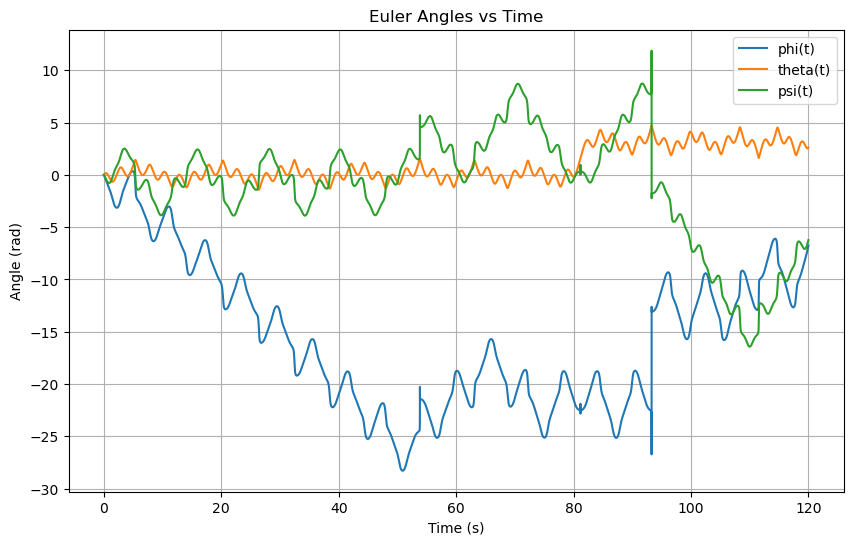

In [32]:
plt.figure(figsize=(10,6))
plt.plot(times, Angles[:,0], label="phi(t)")
plt.plot(times, Angles[:,1], label="theta(t)")
plt.plot(times, Angles[:,2], label="psi(t)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.title("Euler Angles vs Time")
plt.legend()
plt.grid(True)
plt.show()


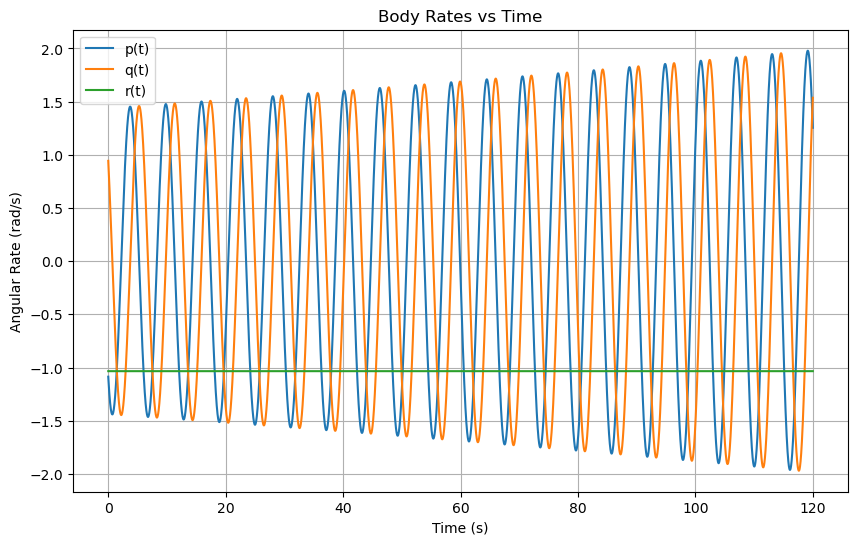

In [33]:
plt.figure(figsize=(10,6))
plt.plot(times, Omegas[:,0], label="p(t)")
plt.plot(times, Omegas[:,1], label="q(t)")
plt.plot(times, Omegas[:,2], label="r(t)")
plt.xlabel("Time (s)")
plt.ylabel("Angular Rate (rad/s)")
plt.title("Body Rates vs Time")
plt.legend()
plt.grid(True)
plt.show()


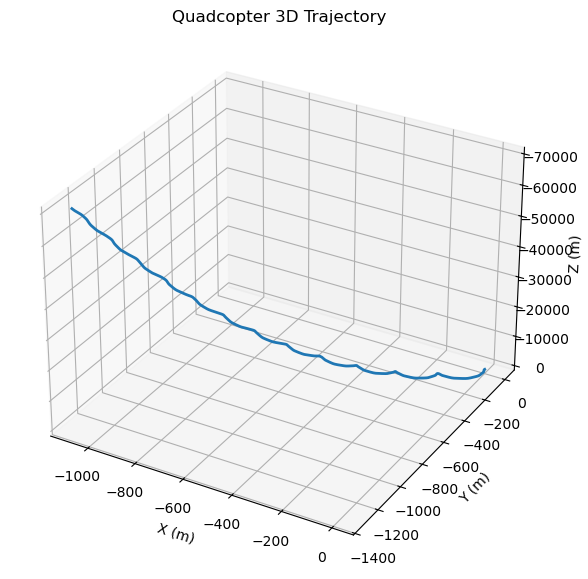

In [34]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(Xs[:,0], Xs[:,1], Xs[:,2], linewidth=2)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Quadcopter 3D Trajectory')
ax.invert_zaxis()  # optional: make height go up visually
plt.show()


In [35]:
#HOVER Q1
def hover_input(t):
    """Constant rotor speeds at hover RPM."""
    omega_h = params["omega_hover"]
    return np.array([omega_h, omega_h, omega_h, omega_h])

def simulate_hover(T=120.0, dt=0.005):
    """
    Simulate hover for duration T (seconds) with timestep dt.
    Returns:
      times, Xs, Angles, Omegas_body, Powers, Energies
    """
    times = np.arange(0.0, T+dt, dt)

    # State variables
    x      = np.array([0.0, 0.0, 1.0])   # start 1 m above ground
    xdot   = np.zeros(3)                 # zero linear velocity
    angles = np.zeros(3)                 # [phi, theta, psi]
    omega_body  = np.zeros(3)            # [p, q, r]

    # Storage for plots
    N = len(times)
    Xs       = np.zeros((N, 3))
    Angles   = np.zeros((N, 3))
    Omegas_b = np.zeros((N, 3))
    Powers   = np.zeros(N)
    Energies = np.zeros(N)

    E = 0.0  # cumulative energy [J]

    for i, t in enumerate(times):
        omegas = hover_input(t)  # rotor speeds [ω1,ω2,ω3,ω4]

        # linear and angular accelerations
        a        = acceleration(omegas, angles, xdot, params)
        omegadot = angular_acceleration(omegas, omega_body, params)

        # integrate rotational motion
        omega_body  = omega_body  + dt * omegadot
        angles      = angles      + dt * euler_rates(*angles, *omega_body)

        # integrate translational motion
        xdot = xdot + dt * a
        x    = x    + dt * xdot

        # power + energy
        P = total_power(omegas, params)   # [W]
        E = E + P * dt                    # [J], simple rectangular integration

        # log data
        Xs[i, :]       = x
        Angles[i, :]   = angles
        Omegas_b[i, :] = omega_body
        Powers[i]      = P
        Energies[i]    = E

    return times, Xs, Angles, Omegas_b, Powers, Energies



In [46]:
T_hover = 1200.0*2  # 2 minutes
dt = 0.005

times, Xs, Angles, Omegas, Powers, Energies = simulate_hover(T=T_hover, dt=dt)



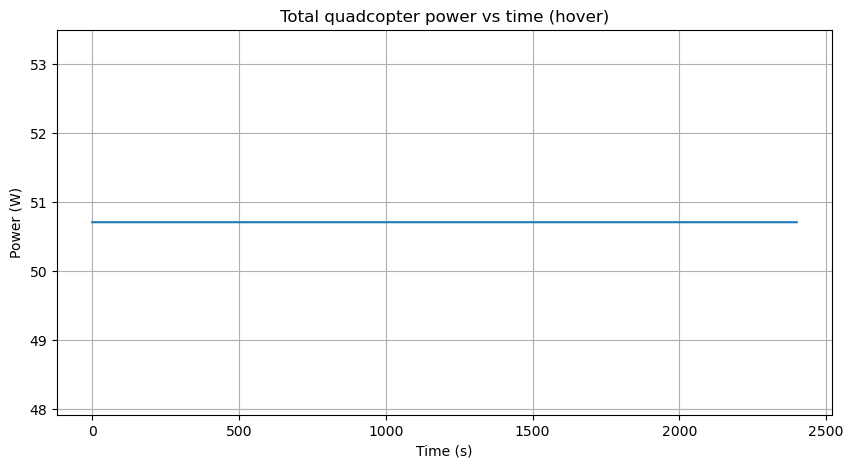

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(times, Powers)
plt.xlabel("Time (s)")
plt.ylabel("Power (W)")
plt.title("Total quadcopter power vs time (hover)")
plt.grid(True)
plt.show()


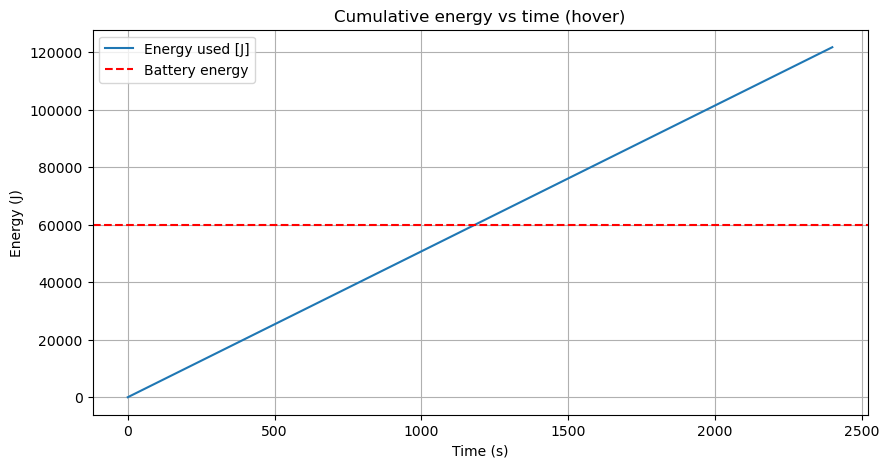

In [48]:
E_batt = params["battery_energy_J"]

plt.figure(figsize=(10,5))
plt.plot(times, Energies, label="Energy used [J]")
plt.axhline(E_batt, color='r', linestyle='--', label="Battery energy")
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.title("Cumulative energy vs time (hover)")
plt.legend()
plt.grid(True)
plt.show()


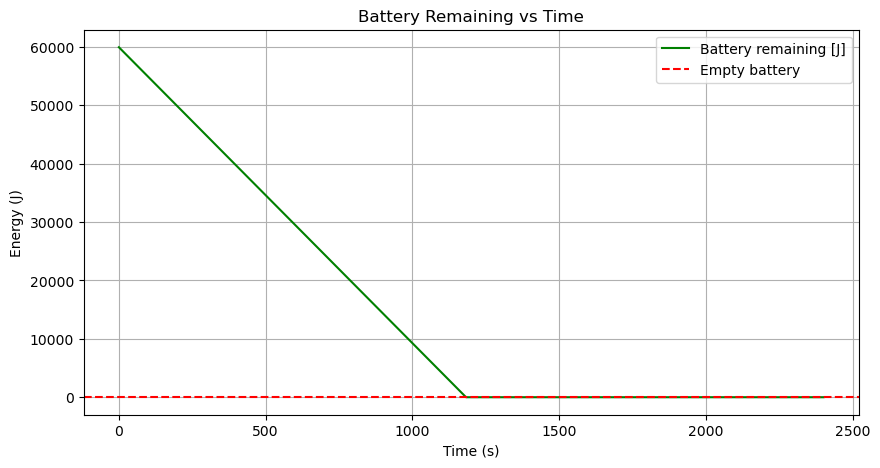

In [49]:
# Compute remaining battery energy
E_batt = params["battery_energy_J"]
battery_remaining = np.maximum(E_batt - Energies, 0)

plt.figure(figsize=(10,5))
plt.plot(times, battery_remaining, color='green', label="Battery remaining [J]")
plt.axhline(0, color='r', linestyle='--', label="Empty battery")
plt.xlabel("Time (s)")
plt.ylabel("Energy (J)")
plt.title("Battery Remaining vs Time")
plt.legend()
plt.grid(True)
plt.show()
